In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
sns.set(font='Arial')

In [2]:
df = pd.read_csv('..\\data\\pareto\\avg_price_act.csv',index_col=0)
df=df.join(pd.read_csv('..\\data\\pareto\\avg_price_sa.csv',index_col=0))

df.index=df.index.rename('Date')
df.index=pd.DatetimeIndex(df.index)

<AxesSubplot:title={'center':'Avg Price'}, xlabel='Date'>

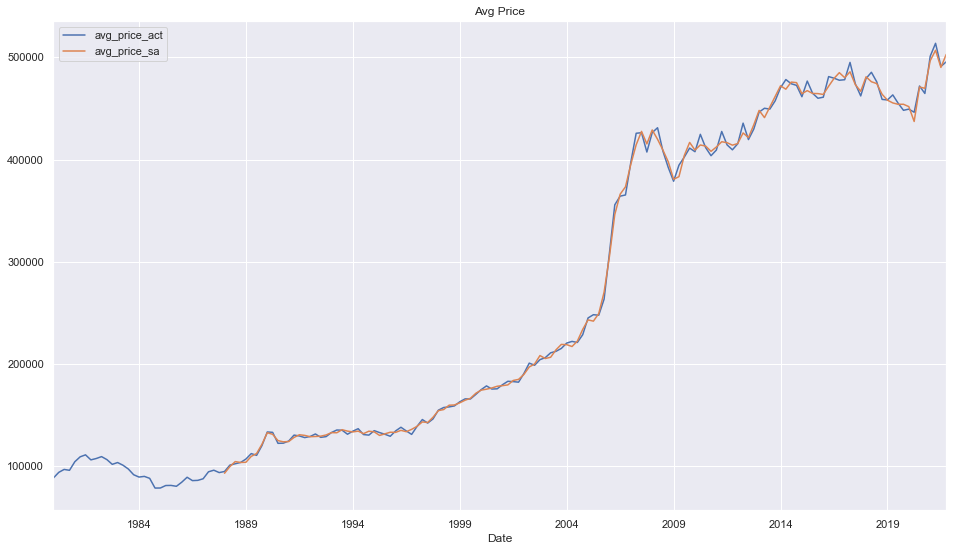

In [3]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,9))

df[['avg_price_act','avg_price_sa']].plot(ax=ax,title='Avg Price')


In [4]:
real_income = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='RealDisposableIncome',engine='openpyxl',index_col=0)[['AB']]
real_income.rename({'AB':'RealDisposableIncome'},axis=1,inplace=True)

real_gdp = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='RealGDP',engine='openpyxl',index_col=0)[['AB']]
real_gdp.rename({'AB':'RealGDP'},axis=1,inplace=True)

unemp = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='Unemployment',engine='openpyxl',index_col=0)[['AB']]
unemp.rename({'AB':'Unemployment'},axis=1,inplace=True)

employment = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='Employment',engine='openpyxl',index_col=0)[['AB']]
employment.rename({'AB':'Employment'},axis=1,inplace=True)

cpi = pd.read_excel('../data/BaselineProvincialForecasts.xlsx',sheet_name='CPI',engine='openpyxl',index_col=0,header=1)[['AB']]
cpi.rename({'AB':'CPI'},axis=1,inplace=True)

prov_econ=real_gdp.join(real_income)
prov_econ=prov_econ.join(unemp)
prov_econ=prov_econ.join(employment)
prov_econ=prov_econ.join(cpi)
prov_econ.index=prov_econ.index.rename('Date')
prov_econ.index=pd.PeriodIndex(prov_econ.index,freq='Q').to_timestamp()


In [5]:
df['avg_price_sa_log'] =np.log(df['avg_price_sa'])

In [6]:
df['avg_price_sa_log_diff']=df['avg_price_sa_log'].diff()

In [7]:
nat_econ=pd.read_excel('../data/BaselineNationalForecasts.xlsx',header=1,index_col=0,engine='openpyxl',sheet_name='Quarterly')[3:-11]
energy = pd.read_excel('../data/BaselineNationalForecasts.xlsx',sheet_name='Energy',header=0,index_col=0,engine='openpyxl')
covid = pd.read_excel('../data/BaselineNationalForecasts.xlsx',sheet_name='COVID',header=0,index_col=0,engine='openpyxl')

In [8]:
nat_econ.index = nat_econ.index.str.replace(' ','')
nat_econ.index=nat_econ.index.rename('Date')
nat_econ.index=pd.PeriodIndex(nat_econ.index,freq='Q').to_timestamp()
energy.index = energy.index.str.replace(' ','')
energy.index=energy.index.rename('Date')
energy.index=pd.PeriodIndex(energy.index,freq='Q').to_timestamp()
covid.index = covid.index.str.replace(' ','')
covid.index=covid.index.rename('Date')
covid.index=pd.PeriodIndex(covid.index,freq='Q').to_timestamp()


In [33]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean error':me, 'mae': mae, 
            'mean percentage error': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})
        

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

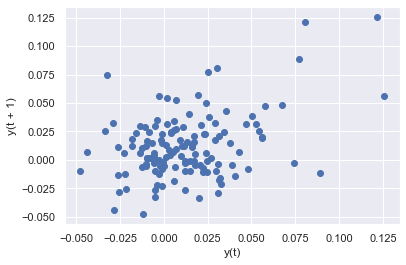

In [34]:
pd.plotting.lag_plot(df['avg_price_sa_log_diff']['1988':])


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
test_df = nat_econ.join(energy).join(df).join(prov_econ).join(covid)

In [10]:
history_df=test_df['1988':'2021']


In [38]:
history_df['CPI']

Date
1988-01-01     67.536693
1988-04-01     68.005108
1988-07-01     68.145014
1988-10-01     68.519212
1989-01-01     69.220147
                 ...    
2020-10-01    145.512828
2021-01-01    146.352459
2021-04-01    148.191545
2021-07-01    150.536396
2021-10-01    151.981480
Freq: QS-OCT, Name: CPI, Length: 136, dtype: float64

RMSE: 0.030


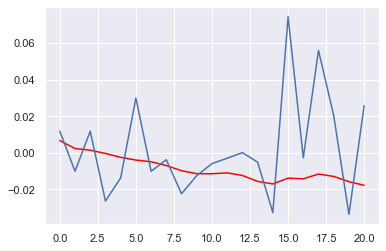

In [39]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log_diff']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

RMSE: 0.071


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


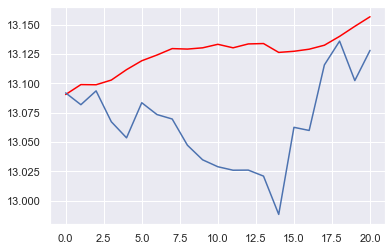

In [40]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [41]:
np.exp(output.summary_frame()['mean'])

0     484311.241229
1     488427.678215
2     488362.679515
3     490316.716755
4     494692.059876
5     498458.900665
6     500898.816817
7     503655.019630
8     503447.126669
9     503985.688512
10    505501.824179
11    503992.904446
12    505662.234806
13    505829.588127
14    502018.296764
15    502502.113770
16    503395.198903
17    505108.246783
18    508940.706547
19    513310.520335
20    517526.394365
Name: mean, dtype: float64

In [42]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 258.947
Date:                Sat, 19 Feb 2022   AIC                           -503.893
Time:                        12:27:50   BIC                           -484.740
Sample:                             0   HQIC                          -496.120
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001      0.000      0.342      0.733      -0.001       0.001
x2             0.0118      0.006      1.955      0.051   -2.75e-05       0.024
const               0   8.95e-16          0      1.000   -1.75e-15    1.75e-15
x3             0.0036      0.004      0.956      0.339      -0.004       0.011
ar.L1          0.4759      0.127      3.744      0.000       0.227       0.725
ma.L1          0.1130      0.152      0.742      0.458      -0.185       0.411
sigma2         0.0006   7.59e-05      8.171      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.36   Prob(JB):                         0.35
Heteroskedasticity (H):               0.71   Skew:                             0.05
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+20. Standard errors may be unstable.
"""

RMSE: 0.043


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


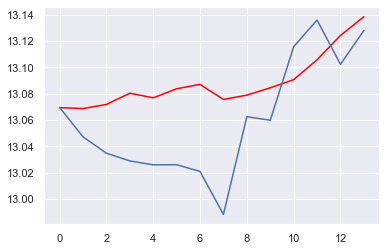

In [43]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)
size = int(len(val)*0.90)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(1,0,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE: 0.070


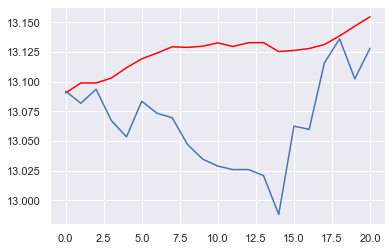

In [44]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = np.array(history_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']].values,dtype=float)
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
exog_train = np.array(exog_train, dtype=float)
predictions = list()
model = SARIMAX(history,order=(2,1,1), seasonal_order=(0,0,0,0),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 259.140
Date:                Sat, 19 Feb 2022   AIC                           -502.279
Time:                        12:27:52   BIC                           -480.390
Sample:                             0   HQIC                          -493.395
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001      0.000      0.362      0.718      -0.001       0.001
x2             0.0117      0.006      1.964      0.050    2.55e-05       0.023
const               0        nan        nan        nan         nan         nan
x3             0.0034      0.004      0.893      0.372      -0.004       0.011
ar.L1          0.2854      1.234      0.231      0.817      -2.134       2.704
ar.L2          0.1074      0.731      0.147      0.883      -1.325       1.540
ma.L1          0.3185      1.240      0.257      0.797      -2.112       2.749
sigma2         0.0006   7.58e-05      8.166      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.30   Prob(JB):                         0.35
Heteroskedasticity (H):               0.72   Skew:                             0.04
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.72e+19. Standard errors may be unstable.
"""

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_20308\2147718930.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


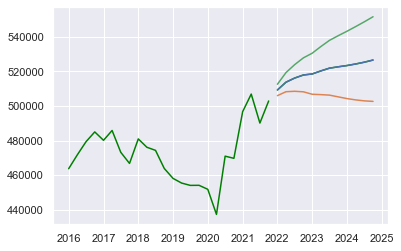

In [14]:
history_df=test_df['1988':'2021']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2016':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))

In [47]:
np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':])

y,mean,mean_ci_lower,mean_ci_upper
2022-01-01,509255.880498,504269.314893,514291.756731
2022-04-01,513754.933067,505405.824176,522241.966011
2022-07-01,516145.133973,504558.492312,527997.850365
2022-10-01,517926.463665,503192.696183,533091.644214
2023-01-01,518515.089638,500765.675937,536893.623308
2023-04-01,520264.867094,499567.276534,541819.980304
2023-07-01,521871.687318,498337.681414,546517.087070
2023-10-01,522663.881751,496441.664018,550271.165953
2024-01-01,523388.684149,494594.697816,553858.979694
2024-04-01,524287.856561,493020.169993,557538.561842


In [48]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 303.141
Date:                Sat, 19 Feb 2022   AIC                           -592.282
Time:                        12:27:53   BIC                           -571.945
Sample:                             0   HQIC                          -584.017
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.000      1.510      0.131      -0.000       0.001
x2             0.0108      0.005      2.042      0.041       0.000       0.021
x3            -0.0222      0.021     -1.069      0.285      -0.063       0.018
x4             0.0025      0.004      0.620      0.535      -0.005       0.010
ar.L1          0.8024      0.089      9.021      0.000       0.628       0.977
ma.L1         -0.4710      0.137     -3.427      0.001      -0.740      -0.202
sigma2         0.0007   7.09e-05      9.197      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 7.38
Prob(Q):                              0.77   Prob(JB):                         0.02
Heteroskedasticity (H):               0.65   Skew:                             0.17
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\makmi\AppData\Local\Temp\ipykernel_20804\360953332.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


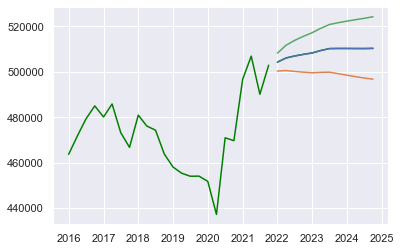

In [52]:

exog =  np.array(test_df[['Interest rate on fixed 5-year mortgages [%]']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['Interest rate on fixed 5-year mortgages [%]']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,0,0), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2016':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))

In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 274.887
Date:                Sat, 19 Feb 2022   AIC                           -543.774
Time:                        12:30:19   BIC                           -535.036
Sample:                             0   HQIC                          -540.223
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0099      0.008      1.195      0.232      -0.006       0.026
ar.L1          1.0000   4.32e-05   2.32e+04      0.000       1.000       1.000
sigma2         0.0009   7.99e-05     11.778      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  21.18   Jarque-Bera (JB):                60.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             1.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_20804\2071274197.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


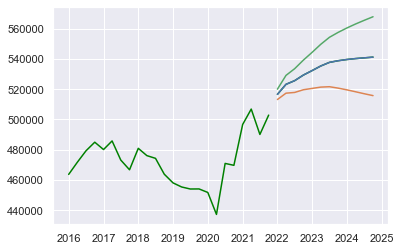

In [75]:

exog =  np.array(test_df[['Interest rate on fixed 5-year mortgages [%]']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['Interest rate on fixed 5-year mortgages [%]']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,4), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2016':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))

In [76]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 300.442
Date:                Sat, 19 Feb 2022   AIC                           -586.884
Time:                        19:53:49   BIC                           -566.547
Sample:                             0   HQIC                          -578.620
                                - 136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0115      0.006      1.856      0.063      -0.001       0.024
ar.L1          0.7706      0.118      6.536      0.000       0.540       1.002
ma.L1         -0.3973      0.146     -2.719      0.007      -0.684      -0.111
ma.L2         -0.1749      0.084     -2.081      0.037      -0.340      -0.010
ma.L3          0.0829      0.100      0.831      0.406      -0.112       0.278
ma.L4          0.1262      0.109      1.157      0.247      -0.088       0.340
sigma2         0.0007    6.7e-05     10.178      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.65
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.50
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

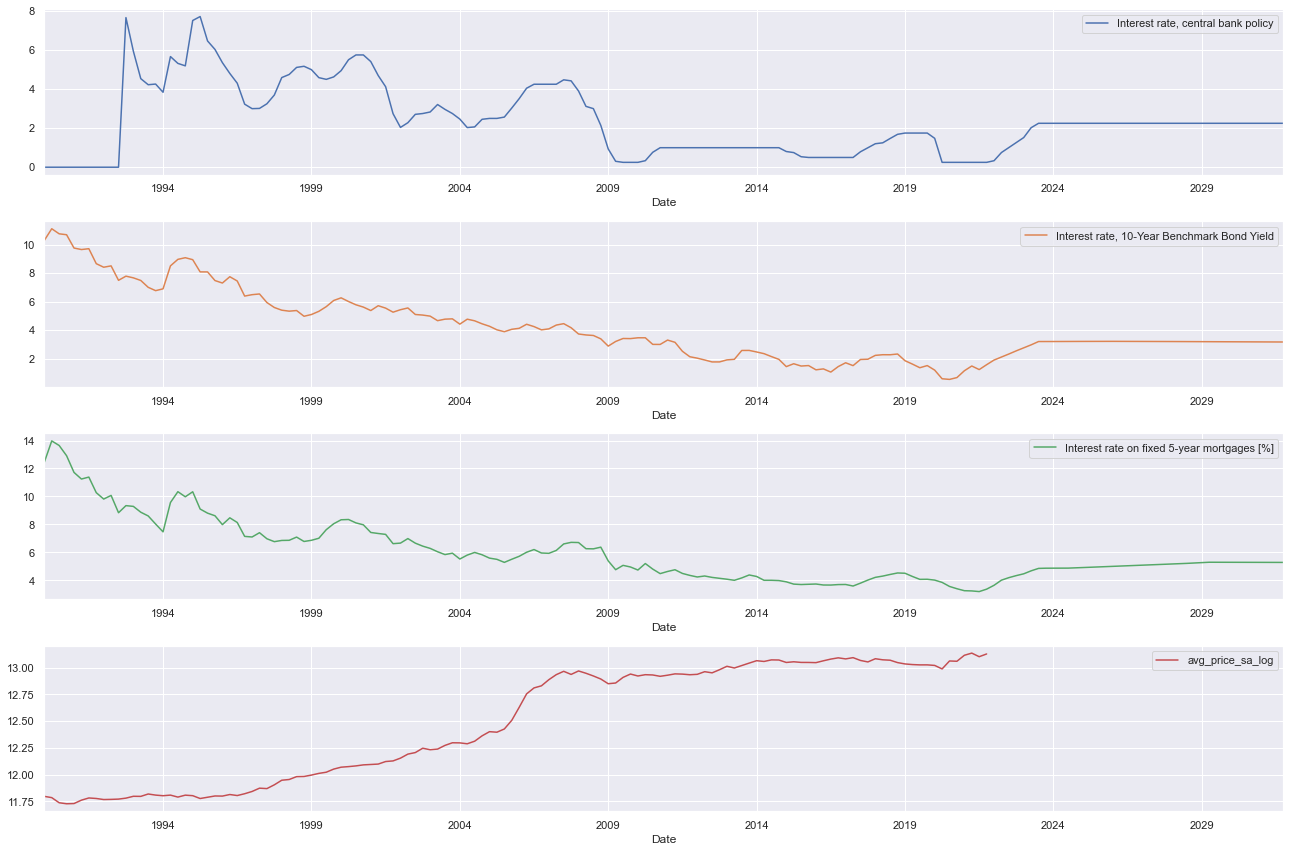

In [55]:

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(18,12))
test_df['1990':][['Interest rate, central bank policy','Interest rate, 10-Year Benchmark Bond Yield','Interest rate on fixed 5-year mortgages [%]','avg_price_sa_log']].plot(ax=ax,subplots=True)
plt.tight_layout()

C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_20804\2697988066.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


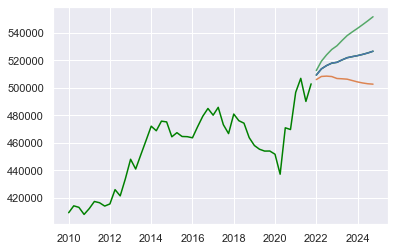

In [89]:

exog =  np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_Base','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2010':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))

In [90]:
np.exp(history[['avg_price_sa_log']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])['2019':'2024']).drop_duplicates().to_csv('price_fcast_base_oil.csv')

In [70]:
np.exp(history)['2020':].resample('A').mean()

,avg_price_sa_log,mean
2020-12-31,457403.00,NaN
2021-12-31,499137.75,NaN
2022-12-31,NaN,514270.602801
2023-12-31,NaN,520828.881450
2024-12-31,NaN,524893.485054
2025-12-31,NaN,NaN
2026-12-31,NaN,NaN
2027-12-31,NaN,NaN
2028-12-31,NaN,NaN
2029-12-31,NaN,NaN


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_20804\2375501586.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


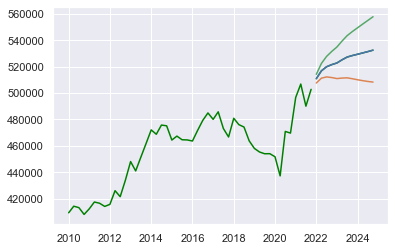

In [81]:

exog =  np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,1), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2010':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))

In [72]:
np.exp(history)['2020':].resample('A').mean()

,avg_price_sa_log,mean
2020-12-31,457403.00,NaN
2021-12-31,499137.75,NaN
2022-12-31,NaN,517360.177188
2023-12-31,NaN,525999.732334
2024-12-31,NaN,531009.410041
2025-12-31,NaN,NaN
2026-12-31,NaN,NaN
2027-12-31,NaN,NaN
2028-12-31,NaN,NaN
2029-12-31,NaN,NaN


C:\Users\makmi\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\makmi\AppData\Local\Temp\ipykernel_20308\43672124.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


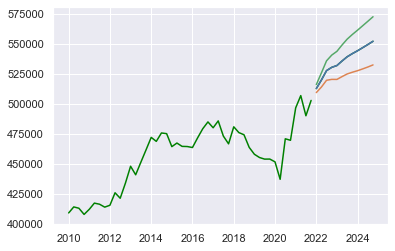

In [15]:

exog =  np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['1988':'2021'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['2022':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,4), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2022',periods=12,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2010':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))

In [16]:
np.exp(history[['avg_price_sa_log']].join(fcast_res[['mean','mean_ci_lower','mean_ci_upper']])['2019':'2024']).drop_duplicates().to_csv('price_fcast_cmhc_oil.csv')

In [78]:
np.exp(history)['2020':].resample('A').mean()

,avg_price_sa_log,mean
2020-12-31,457403.00,NaN
2021-12-31,499137.75,NaN
2022-12-31,NaN,522645.274873
2023-12-31,NaN,537141.578129
2024-12-31,NaN,548108.261358
2025-12-31,NaN,NaN
2026-12-31,NaN,NaN
2027-12-31,NaN,NaN
2028-12-31,NaN,NaN
2029-12-31,NaN,NaN


C:\Users\makmi\AppData\Local\Temp\ipykernel_20804\3578522676.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(fcast_res[['mean']])


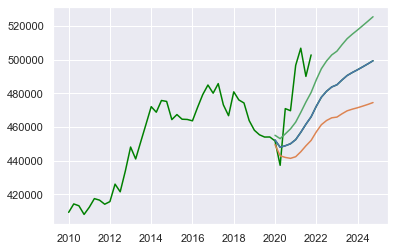

In [84]:
history_df=test_df['1988':'2019']
val = np.array(history_df[['avg_price_sa_log']].values,dtype=float)

exog =  np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['1988':'2019'].values,dtype=float)
exog_fcast = np.array(test_df[['WTI_CMHC','Interest rate on fixed 5-year mortgages [%]','COVID-19','CPI']]['2020':'2024'].values,dtype=float)


model = SARIMAX(val,order=(1,1,4), seasonal_order=(0,0,0,0),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(20,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2020',periods=20,freq='qs-oct')

history = test_df[['avg_price_sa_log']]['2010':]
history=history.append(fcast_res[['mean']])
#history.index = pd.date_range(start='2019',end='2025',freq='qs-oct')
plt.plot(np.exp(history),color='green')

plt.plot(np.exp(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2020':]))